## CNN 

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using plaidml.keras.backend backend.


### CNN Model 
- The function below will compile and return a CNN model given the input dimensions 
- Categorical Crossentropy was used because the model is used to predict between three classes (0 = No Weapon, 1 = Handgun, 2 = Rifle) 
- Softmax output was used because this is a ternary classification problem 
- To ensure that training continued for more than 20 epochs
- Dimension for thie model is optimized at (150, 150, 1) 
- All visualization functions can be found in the Viz.py file within the PyFunctions folder

In [2]:
#change edge parameter to false if you are using a non edges train_test_split
edge = True
x_train, x_test, y_train, y_test = func.get_samples('normal', edge = edge)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(6062, 150, 150, 1) (674, 150, 150, 1)
(6062, 3) (674, 3)


- Running the cell below will show you what the input images look like.  
- Creating these images used a gaussian filter that outline the edges within a photo 
- Using this approach allowed the algorithm to learn distinctive shapes between weapons

In [3]:
import cv2 

cv2.imshow('test', x_train[1000])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def get_conv_model_normal(dim):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 



if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)
print(normal_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Conv2D)         (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 17, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
__________

# With Augmentation
- First started with augmentation of each image to determine if this would make the accuracy better

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/CNN-ModelCheckpointWeightsAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32


augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/1000


INFO:plaidml:Analyzing Ops: 90 of 422 operations complete


 57/190 [========>.....................] - ETA: 34s - loss: 32.8080 - acc: 0.4178

INFO:plaidml:Analyzing Ops: 90 of 422 operations complete


190/190 [==============================] - 43s 227ms/step - loss: 19.8253 - acc: 0.4670 - val_loss: 12.1119 - val_acc: 0.5119

Epoch 00001: val_loss improved from inf to 12.11189, saving model to ModelWeights/CNN-ModelCheckpointWeightsAugment.h5
Epoch 2/1000
190/190 [==============================] - 19s 100ms/step - loss: 12.1796 - acc: 0.4688 - val_loss: 11.8818 - val_acc: 0.6825

Epoch 00002: val_loss improved from 12.11189 to 11.88182, saving model to ModelWeights/CNN-ModelCheckpointWeightsAugment.h5
Epoch 3/1000
190/190 [==============================] - 19s 101ms/step - loss: 11.8486 - acc: 0.6551 - val_loss: 11.9929 - val_acc: 0.7404

Epoch 00003: val_loss did not improve from 11.88182
Epoch 4/1000
190/190 [==============================] - 19s 100ms/step - loss: 11.6281 - acc: 0.7383 - val_loss: 11.5231 - val_acc: 0.7864

Epoch 00004: val_loss improved from 11.88182 to 11.52310, saving model to ModelWeights/CNN-ModelCheckpointWeightsAugment.h5
Epoch 5/1000
190/190 [============

### Loss & Accuracy With Augment

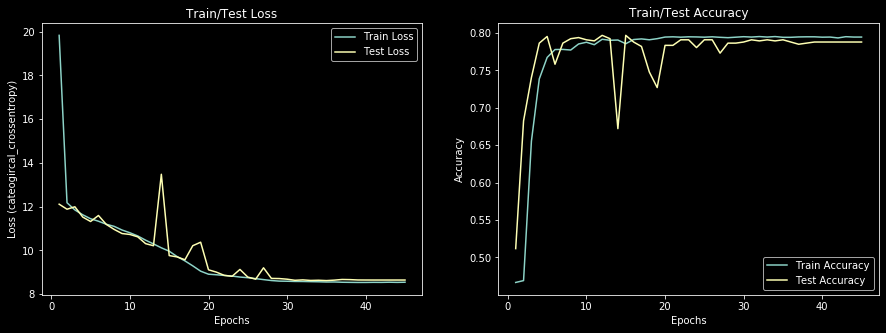

In [7]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/CNNModelAugment.png')  

### AUC and ROC Curves With Augment

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.970059880239521
HandGun: 0.8169014084507041
Rifle: 0.0


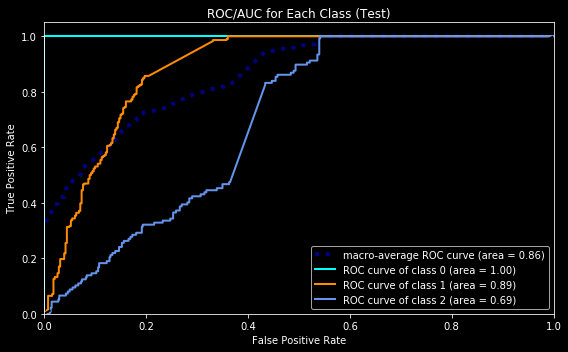

In [5]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/CNN-ModelCheckpointWeightsAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/ROCAUCAugment.png')

### Confusion Matrix With Augment

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


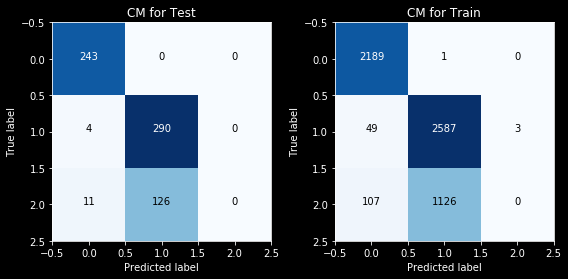

In [4]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/CNN-ModelCheckpointWeightsAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/CMAugment.png')


# No Augmention

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)


normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


Train on 6062 samples, validate on 674 samples
Epoch 1/1000


INFO:plaidml:Analyzing Ops: 92 of 422 operations complete


6062/6062 [==============================] - 43s 7ms/step - loss: 20.5382 - acc: 0.5599 - val_loss: 12.2856 - val_acc: 0.7211

Epoch 00001: val_loss improved from inf to 12.28558, saving model to ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5
Epoch 2/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 12.1792 - acc: 0.7181 - val_loss: 11.7517 - val_acc: 0.7715

Epoch 00002: val_loss improved from 12.28558 to 11.75174, saving model to ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5
Epoch 3/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 11.6702 - acc: 0.7371 - val_loss: 11.5390 - val_acc: 0.7596

Epoch 00003: val_loss improved from 11.75174 to 11.53898, saving model to ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5
Epoch 4/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 11.4880 - acc: 0.7636 - val_loss: 11.4359 - val_acc: 0.7804

Epoch 00004: val_loss improved from 11.53898 to 11.43591, saving model to ModelW

Epoch 66/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 1.8360 - acc: 0.9988 - val_loss: 2.7609 - val_acc: 0.8412

Epoch 00066: val_loss improved from 2.76097 to 2.76091, saving model to ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5
Epoch 67/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 1.8251 - acc: 0.9987 - val_loss: 2.7646 - val_acc: 0.8427

Epoch 00067: val_loss did not improve from 2.76091
Epoch 68/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 1.8200 - acc: 0.9988 - val_loss: 2.7652 - val_acc: 0.8412

Epoch 00068: val_loss did not improve from 2.76091
Epoch 69/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 1.8190 - acc: 0.9990 - val_loss: 2.7654 - val_acc: 0.8412

Epoch 00069: val_loss did not improve from 2.76091
Epoch 70/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 1.8176 - acc: 0.9988 - val_loss: 2.7654 - val_acc: 0.8412

Epoch 00070: val_loss did no

### Loss and Accuracy without Augment

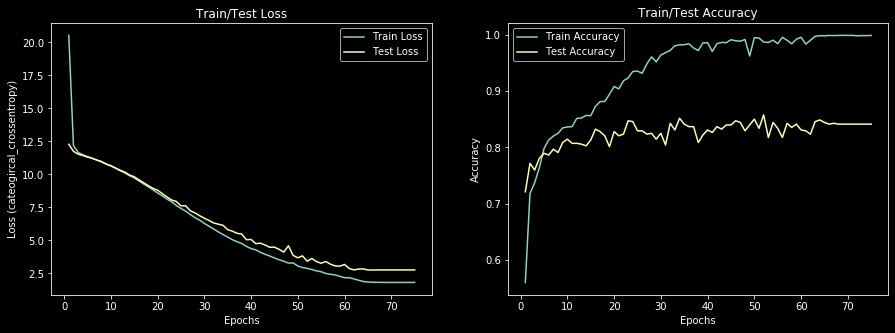

In [12]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/CNNModelNoAugment.png')  

### ROC and AUC without Augment

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9979381443298969
HandGun: 0.8237232289950577
Rifle: 0.5859375000000001


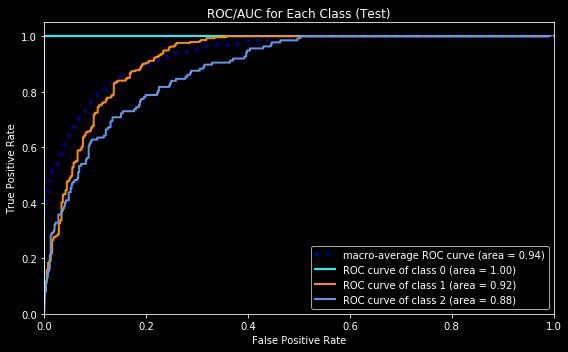

In [6]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/ROCAUCNoAugment.png')

### Confusion Matrix Without Augment

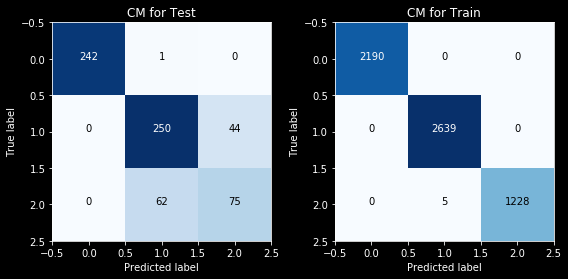

In [6]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/CNN-ModelCheckpointWeightsNoAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/CMNoAugment.png')


## Results

- Comparing the confusion matrix of the augmented model with the non-augmented model, we can see that the non-augmented model performs much better at detection the presence of the weapon.  
- This difference can be due to the fact that the images that are being fed into the algorithm are already processes in a way that only makes it more confusing when applying augmentation as well
- The model weights `CNN-ModelCheckpointWeightsNoAugment.h5` correspond to the final model used throughout the visualizations found in `OpenCVTesting` notebook